# The Problem:
Forecast Ethereum prices based on historical data to support investment decisions.

<img src="./OIP.jpg">

# Data Collection:

Gather historical Ethereum price data from kaggle

# Importing the libraries

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Importing the dataset

In [14]:
dataset = pd.read_csv("ETH-USD.csv")

In [15]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [16]:
dataset.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

# Data Preprocessing

Convert the 'Date' column to datetime and set it as the index

In [17]:
dataset.shape

(1598, 7)

In [18]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)

In [19]:
dataset.index.to_series().diff()

Date
2017-11-09      NaT
2017-11-10   1 days
2017-11-11   1 days
2017-11-12   1 days
2017-11-13   1 days
              ...  
2022-03-21   1 days
2022-03-22   1 days
2022-03-23   1 days
2022-03-24   1 days
2022-03-25   1 days
Name: Date, Length: 1598, dtype: timedelta64[ns]

Check for missing values

In [20]:
missing_values = dataset.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# Data Exploration

Ethereum prices over time

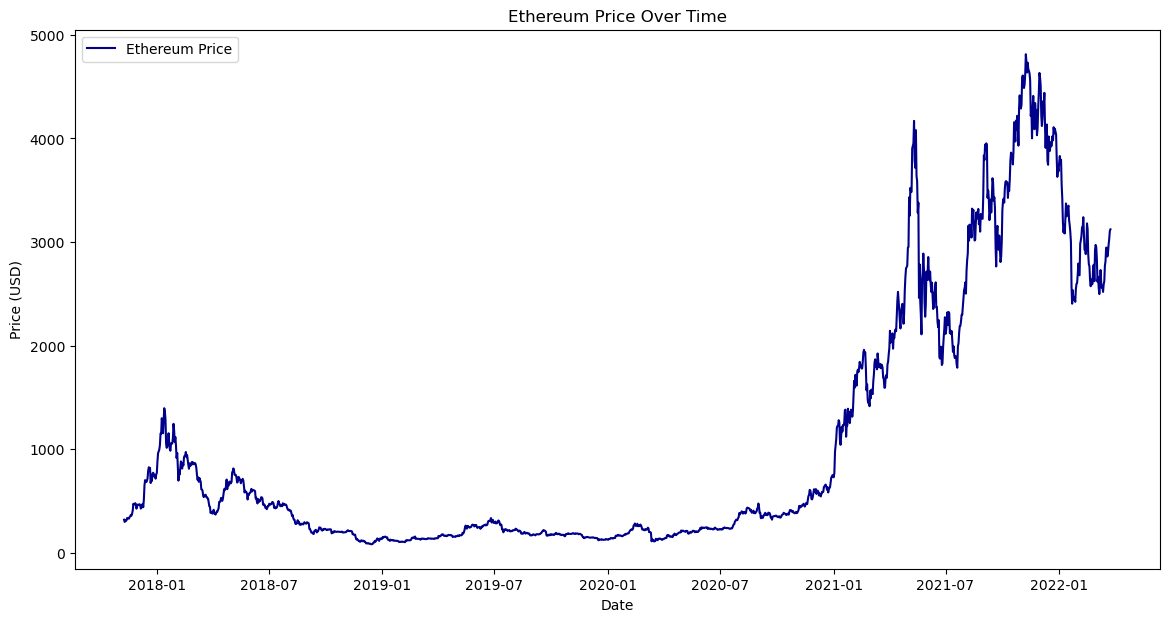

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(dataset['Close'], label='Ethereum Price', color='darkblue')
plt.title('Ethereum Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Close Price USD Over Month

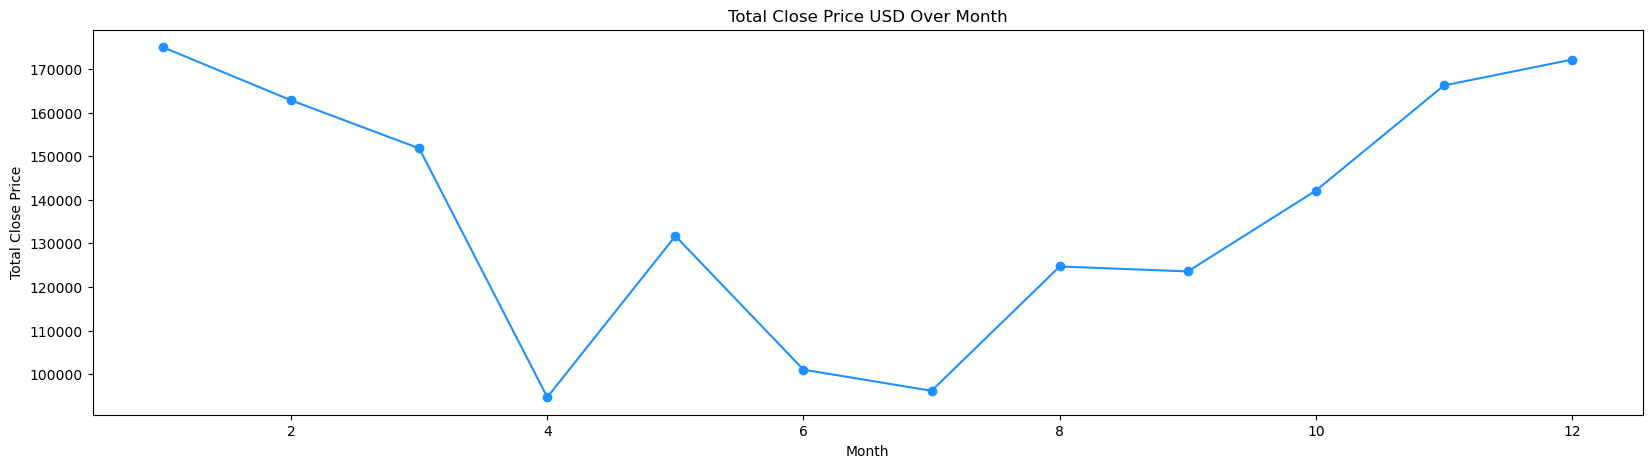

In [22]:
dataset = dataset.reset_index()
dataset['Month'] = dataset['Date'].dt.month

monthly_sum = dataset.groupby("Month")["Close"].sum().reset_index()

plt.figure(figsize=(20, 5))
plt.plot(monthly_sum['Month'], monthly_sum['Close'], marker='o', color='dodgerblue')
plt.title('Total Close Price USD Over Month')
plt.xlabel('Month')
plt.ylabel('Total Close Price')
plt.show()

Visualize the distribution of Ethereum prices

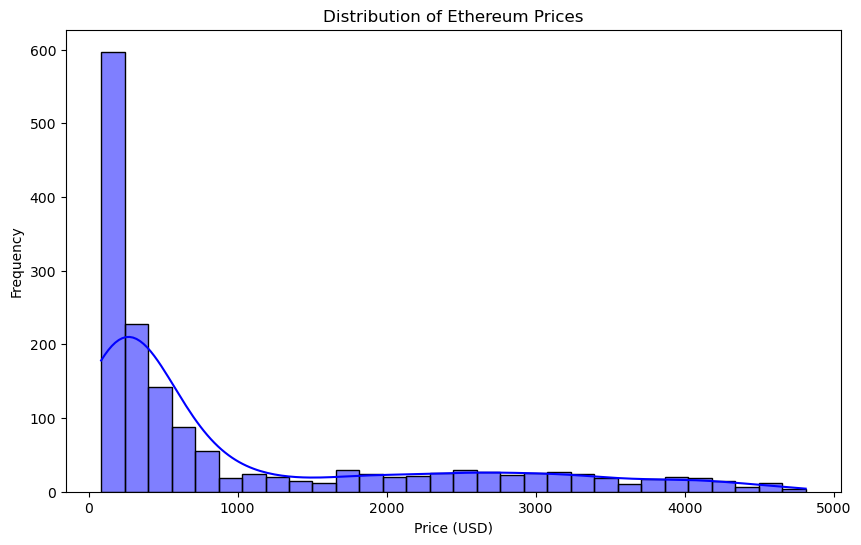

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Close'], bins=30, kde=True, color='blue')
plt.title('Distribution of Ethereum Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

Plot a box plot of Ethereum prices by year

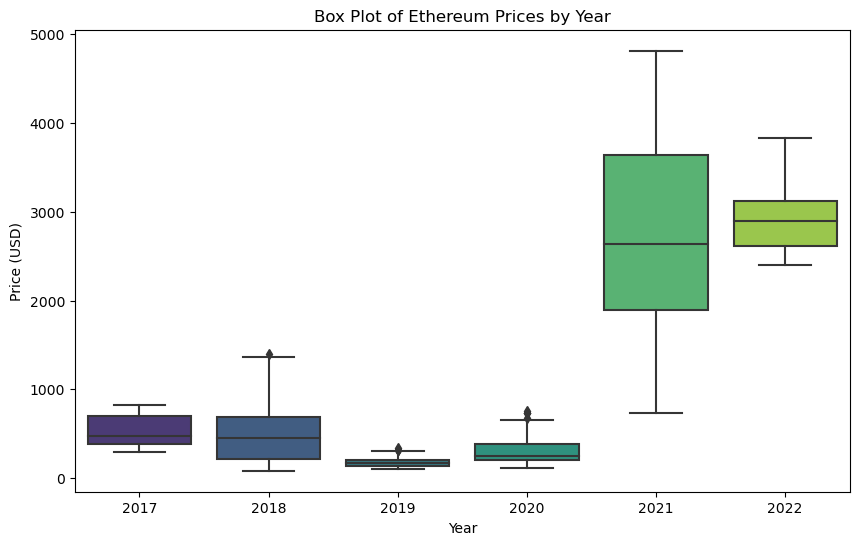

In [25]:
dataset.set_index('Date', inplace=True)
palette = sns.color_palette('viridis', n_colors=len(dataset.index.year.unique()))
plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset.index.year, y='Close', data=dataset, palette=palette)
plt.title('Box Plot of Ethereum Prices by Year')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.show()

Correlation Matrix

<Axes: >

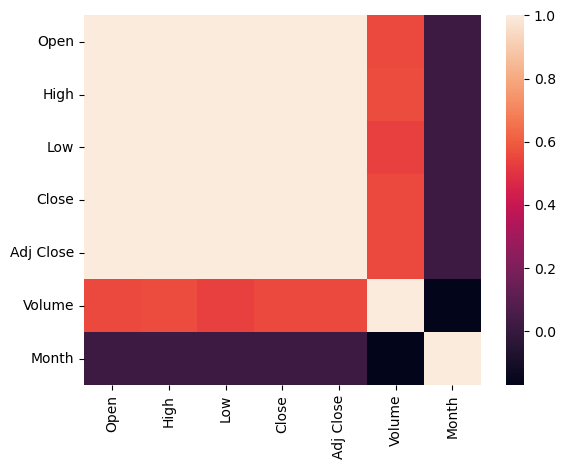

In [26]:
sns.heatmap(dataset.corr())

# Feature engineering

Simple Moving Average (SMA)

In [27]:
sma_window = 50
dataset['SMA_50'] = dataset['Close'].rolling(window=sma_window).mean()

Exponential Moving Average (EMA)

In [28]:
ema_window = 12
alpha = 2 / (ema_window + 1)
dataset['EMA_12'] = dataset['Close'].ewm(alpha=alpha, adjust=False).mean()

Relative Strength Index (RSI)

In [29]:
rsi_window = 14
price_diff = dataset['Close'].diff(1)
gain = price_diff.where(price_diff > 0, 0)
loss = -price_diff.where(price_diff < 0, 0)

avg_gain = gain.rolling(window=rsi_window, min_periods=1).mean()
avg_loss = loss.rolling(window=rsi_window, min_periods=1).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

dataset['RSI_14'] = rsi

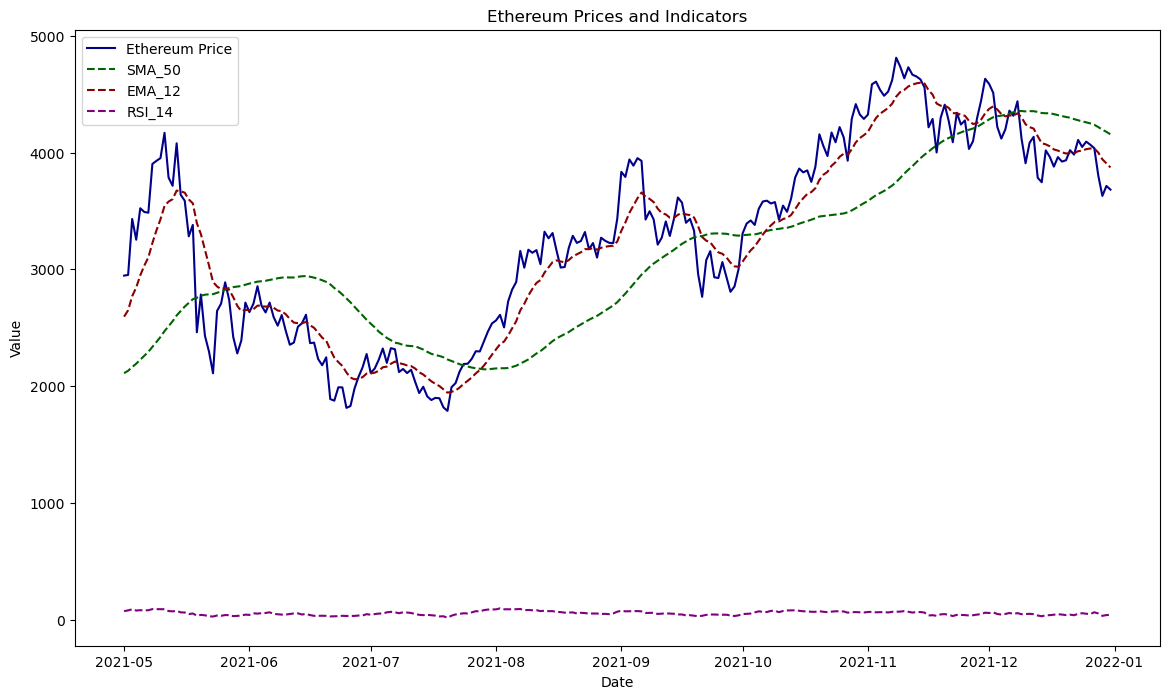

In [30]:
start_date = '2021-05-01'
end_date = '2021-12-31'

# Visualize Ethereum prices along with the extracted indicators
plt.figure(figsize=(14, 8))

# Plot Ethereum prices
plt.plot(dataset['Close'][start_date:end_date], label='Ethereum Price', color='darkblue')

# Plot Simple Moving Average (SMA)
plt.plot(dataset['SMA_50'][start_date:end_date], label='SMA_50', color='darkgreen', linestyle='--')

# Plot Exponential Moving Average (EMA)
plt.plot(dataset['EMA_12'][start_date:end_date], label='EMA_12', color='darkred', linestyle='--')

# Plot Relative Strength Index (RSI)
plt.plot(dataset['RSI_14'][start_date:end_date], label='RSI_14', color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Ethereum Prices and Indicators')
plt.legend()
plt.show()

In [31]:
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Month         0
SMA_50       49
EMA_12        0
RSI_14        1
dtype: int64


In [32]:
dataset.dropna(inplace = True)
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Month        0
SMA_50       0
EMA_12       0
RSI_14       0
dtype: int64


# Splitting the dataset into the Training set and Test set

In [33]:
train_size = int(len(dataset)*0.8)

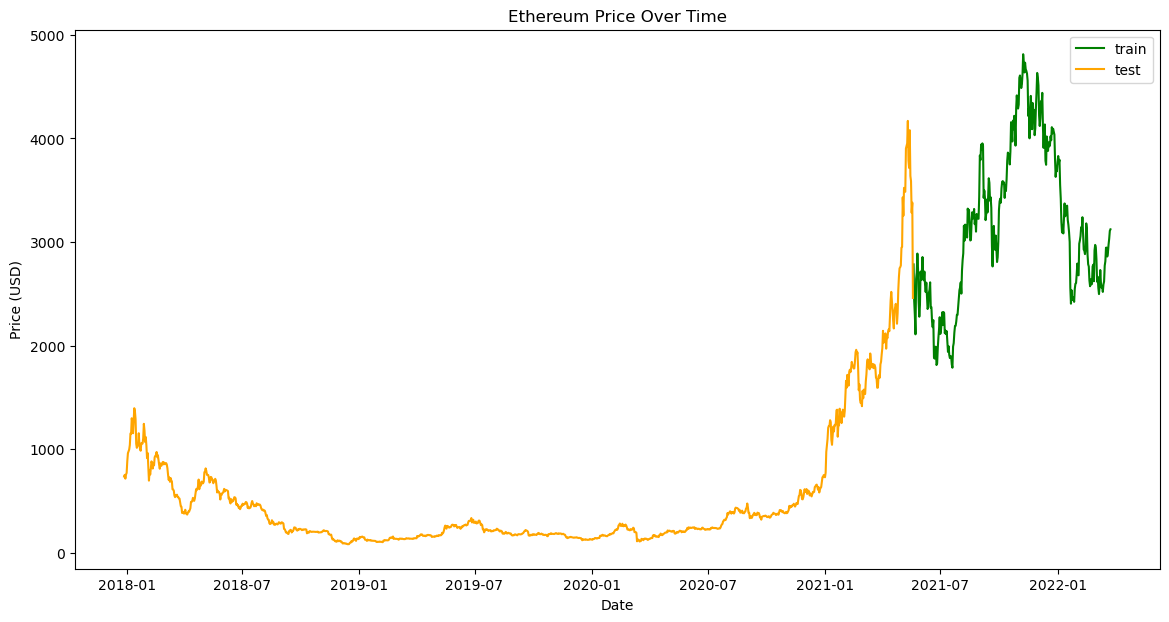

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(dataset[train_size:]['Close'], label='train', color='green')
plt.plot(dataset[:train_size]['Close'], label='test', color='orange')
plt.title('Ethereum Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [35]:
dataset = dataset.reset_index()

In [36]:
scaler_y = StandardScaler()
y = scaler_y.fit_transform(dataset.loc[:, "Close"].values.reshape(-1,1))

In [37]:
y.shape

(1549, 1)

In [38]:
time_steps = 14
X, Y = [], []
for i in range(time_steps, len(y)):
    X.append(y[i - time_steps:i, 0])
    Y.append(y[i, 0])

X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1535, 14, 1) Y.shape (1535,)


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Training the LSTM model on the Training set

In [40]:
i = Input(shape=(time_steps, 1))
x = LSTM(64)(i)
x = Dense(1)(x)
model = Model(i, x)

In [41]:
model.compile(
  loss='mse',
  optimizer="adam",
)

In [42]:
lstm = model.fit(
  X_train, Y_train,
  epochs=50,
  validation_split = 0.02)

Epoch 1/50
38/38 [==============================] - 3s 22ms/step - loss: 0.1091 - val_loss: 1.1659
Epoch 2/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.3567
Epoch 3/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.3695
Epoch 4/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.3568
Epoch 5/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.3588
Epoch 6/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.3137
Epoch 7/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.3021
Epoch 8/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.2990
Epoch 9/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.2502
Epoch 10/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.2682
Epoch 11/50
38/3

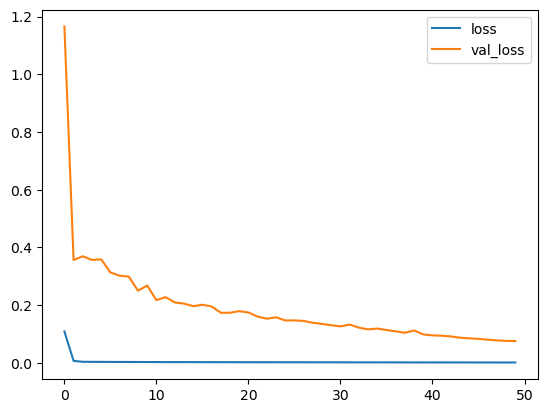

In [43]:
plt.plot(lstm.history['loss'], label='loss')
plt.plot(lstm.history['val_loss'], label='val_loss')
plt.legend()

# Testing LSTM model

In [44]:
loss = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')

10/10 [==============================] - 0s 4ms/step - loss: 0.0215
Test Loss: 0.021526040509343147


10/10 [==============================] - 1s 6ms/step


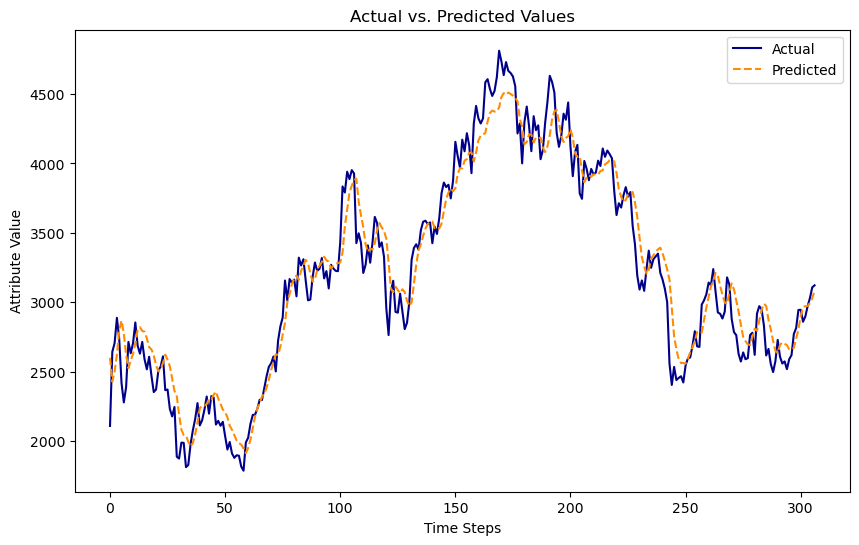

In [45]:
predictions = model.predict(X_test)

predictions = scaler_y.inverse_transform(predictions)
Y_test_actual = scaler_y.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(Y_test_actual, label='Actual', color = "darkblue")
plt.plot(predictions, label='Predicted', linestyle='dashed', color = "darkorange")
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Attribute Value')
plt.legend()
plt.show()

# Training the bi-directional long short-term memory (Bi-LSTM) model on the Training set

In [46]:
i = Input(shape=(time_steps, 1))
x = Bidirectional(LSTM(64))(i)
x = Dense(1)(x)
model = Model(i, x)

In [47]:
model.compile(
  loss='mse',
  optimizer="adam",
)

In [48]:
lstm = model.fit(
  X_train, Y_train,
  epochs=50,
  validation_split = 0.02)

Epoch 1/50
38/38 [==============================] - 6s 39ms/step - loss: 0.0499 - val_loss: 0.4310
Epoch 2/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0043 - val_loss: 0.2537
Epoch 3/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.2635
Epoch 4/50
38/38 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.2511
Epoch 5/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0034 - val_loss: 0.2519
Epoch 6/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.2656
Epoch 7/50
38/38 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.2287
Epoch 8/50
38/38 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.2379
Epoch 9/50
38/38 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.2041
Epoch 10/50
38/38 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.2403
Epoch 11/50


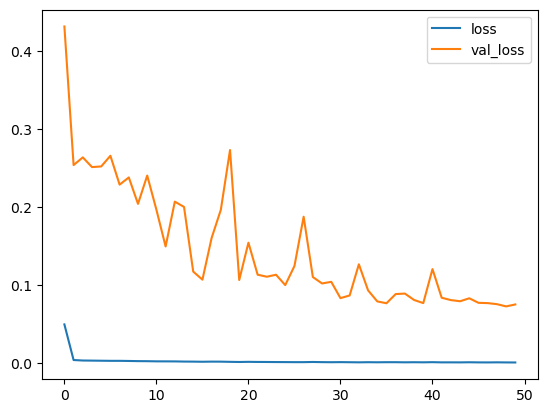

In [50]:
plt.plot(lstm.history['loss'], label='loss')
plt.plot(lstm.history['val_loss'], label='val_loss')
plt.legend()

# Testing Bi-LSTM model

In [51]:
loss = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')

10/10 [==============================] - 0s 5ms/step - loss: 0.0197
Test Loss: 0.019727548584342003


10/10 [==============================] - 1s 4ms/step


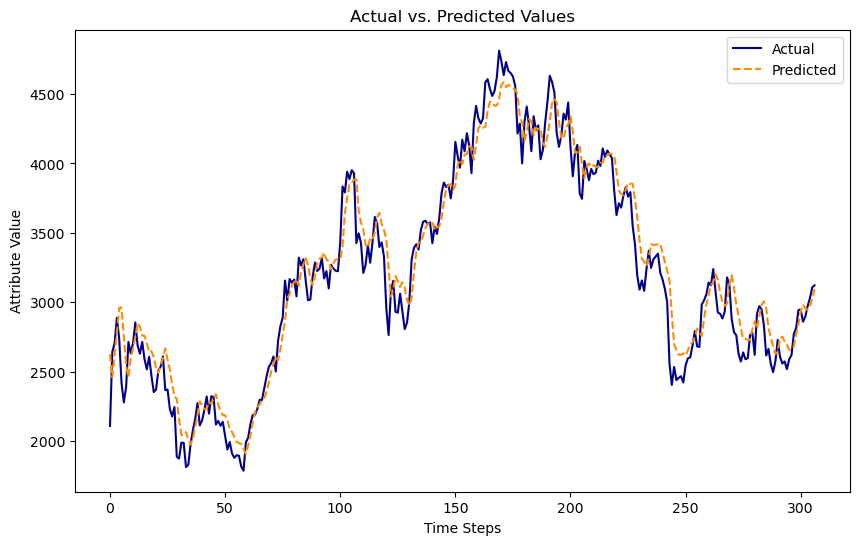

In [52]:
predictions = model.predict(X_test)

predictions = scaler_y.inverse_transform(predictions)
Y_test_actual = scaler_y.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(Y_test_actual, label='Actual', color = "darkblue")
plt.plot(predictions, label='Predicted', linestyle='dashed', color = "darkorange")
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Attribute Value')
plt.legend()
plt.show()

# Training the Echo State Network model on the Training set

Mean Squared Error on Test Data: 0.04869586120787524


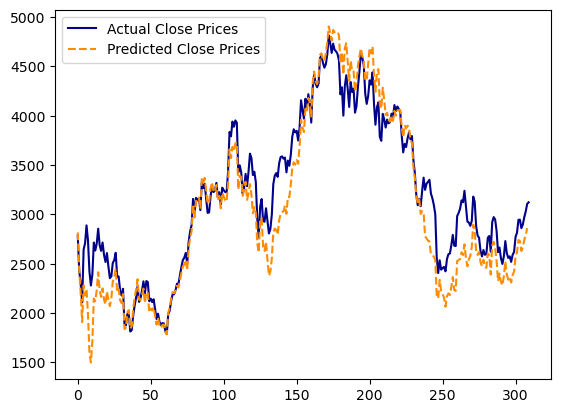

In [77]:
from sklearn.linear_model import LinearRegression
data = y.reshape(-1,1)

# Hyperparameters
input_size = 1
reservoir_size = 100
output_size = 1
leak_rate = 0.3
spectral_radius = 0.9

# Training parameters
train_ratio = 0.8
train_size = int(train_ratio * len(data))

# Split the data into training and testing sets
train_data, test_data = data[:train_size], data[train_size:]

# Initialize weights
input_weights = np.random.rand(reservoir_size, input_size) - 0.5
reservoir_weights = np.random.rand(reservoir_size, reservoir_size) - 0.5
reservoir_weights *= spectral_radius / max(np.abs(np.linalg.eigvals(reservoir_weights)))
output_weights = np.random.rand(output_size, reservoir_size) - 0.5

# Initialize reservoir states
reservoir_states = np.zeros((reservoir_size, 1))

# Initialize output
output = np.zeros_like(data)

# Prepare lagged features for linear regression
lagged_features = np.zeros((train_size, reservoir_size + 1))
lagged_features[:, 0] = 1  # Bias term
lagged_features[:, 1:] = reservoir_states[:train_size].T

# Run the ESN for training
for t in range(train_size):
    input_state = train_data[t, :].reshape((input_size, 1))
    reservoir_states = (1 - leak_rate) * reservoir_states + leak_rate * np.tanh(
        np.dot(reservoir_weights, reservoir_states) + np.dot(input_weights, input_state)
    )
    lagged_features[t, 1:] = reservoir_states.T

# Use Linear Regression for output weights training
lr = LinearRegression()
lr.fit(lagged_features, train_data.flatten())
output_weights_train = lr.coef_[1:].reshape(output_size, reservoir_size)

# Run the ESN for testing
for t in range(train_size, len(data)):
    input_state = data[t, :].reshape((input_size, 1))
    reservoir_states = (1 - leak_rate) * reservoir_states + leak_rate * np.tanh(
        np.dot(reservoir_weights, reservoir_states) + np.dot(input_weights, input_state)
    )
    lagged_feature_test = np.concatenate([reservoir_states.flatten()])
    output[t, :] = np.dot(output_weights_train, lagged_feature_test)

# Evaluate the model
mse = mean_squared_error(data[train_size:], output[train_size:])
print(f"Mean Squared Error on Test Data: {mse}")

# Plot only the test data along with predicted values
plt.plot(scaler_y.inverse_transform(data[train_size:]), label="Actual Close Prices", color = "darkblue")
plt.plot(scaler_y.inverse_transform(output[train_size:-1]), label="Predicted Close Prices", color = "darkorange", linestyle='dashed')
plt.legend()
plt.show()